# Titanic Competition - Model - Ramin F.

in this notebook we are going to develope a machine learning model for titanic competition. for this purpose we are going to test multiple approaches and algorithms to investigate which one will have the most accuracy.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('darkgrid')

In [41]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Droping unwanted features

there are some useless features for ML models, in this section we are going to drop them.

In [42]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Making Categorical Variables Continious (One-Hot)
there are some categorical variables in dataset, i.e. "Pclass", "Sex" and "Embarked". in order to make this features usable by ML models we must make them continious. we are going to use one-hot encoding approach for this matter.

In [43]:
dummy_pclass = pd.get_dummies(train['Pclass'], prefix='Pclass')
dummy_sex = pd.get_dummies(train['Sex'], prefix='Sex')
dummy_embarked = pd.get_dummies(train['Embarked'], prefix='Embarked')
train = pd.concat([train, dummy_pclass, dummy_sex, dummy_embarked], axis=1)
train.drop(['Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)
train

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.00,1,0,7.25,0,0,1,0,1,0,0,1
1,1,38.00,1,0,71.28,1,0,0,1,0,1,0,0
2,1,26.00,0,0,7.92,0,0,1,1,0,0,0,1
3,1,35.00,1,0,53.10,1,0,0,1,0,0,0,1
4,0,35.00,0,0,8.05,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.00,0,0,13.00,0,1,0,0,1,0,0,1
887,1,19.00,0,0,30.00,1,0,0,1,0,0,0,1
888,0,NaN,1,2,23.45,0,0,1,1,0,0,0,1
889,1,26.00,0,0,30.00,1,0,0,0,1,1,0,0


# Treating Missing Values Problem

as we saw in the EDA notebook, some records have missing values. to be more specific, in "Age" feature we have 177 records with missing data and 3 records with missing data in "Embarked" Features. the "Cabin" feature also has some missing values but since we will going to drop that feature, there is no need for imputing that feature.

In [44]:
train.isnull().sum()

Survived        0
Age           177
SibSp           0
Parch           0
Fare            0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [45]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [46]:
train_imputation_matrix = train.values
imp = IterativeImputer(max_iter = 10)
predicted_imp = np.round(imp.fit_transform(train_imputation_matrix))

In [47]:
train_imputed = pd.DataFrame(predicted_imp, columns=['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
                                                     'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])

train = train.merge(train_imputed, on=train.index, how='left')
train.drop(['key_0', 'Survived_x', 'Age_x', 'SibSp_x', 'Parch_x', 'Fare_x', 'Pclass_1_x', 'Pclass_2_x', 'Pclass_3_x',
            'Sex_female_x', 'Sex_male_x', 'Embarked_C_x', 'Embarked_Q_x', 'Embarked_S_x'], axis=1, inplace=True)
train.rename(columns={'Survived_y': 'Survived',
                      'Age_y': 'Age',
                      'SibSp_y': 'SibSp',
                      'Parch_y': 'Parch',
                      'Fare_y': 'Fare',
                      'Pclass_1_y': 'Pclass_1',
                      'Pclass_2_y': 'Pclass_2',
                      'Pclass_3_y': 'Pclass_3',
                      'Sex_female_y': 'Sex_female',
                      'Sex_male_y': 'Sex_male',
                      'Embarked_C_y': 'Embarked_C',
                      'Embarked_Q_y': 'Embarked_Q',
                      'Embarked_S_y': 'Embarked_S'}, inplace=True)
train

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.00,22.00,1.00,0.00,7.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
1,1.00,38.00,1.00,0.00,71.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2,1.00,26.00,0.00,0.00,8.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
3,1.00,35.00,1.00,0.00,53.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
4,0.00,35.00,0.00,0.00,8.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.00,27.00,0.00,0.00,13.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
887,1.00,19.00,0.00,0.00,30.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
888,0.00,24.00,1.00,2.00,23.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
889,1.00,26.00,0.00,0.00,30.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


In [49]:
train.isnull().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

as you can see in the cell above all of the 177 records with missing values in "Age" feature had been imputed.

# Splitting Dependent and Independent Variables
next step we have to do is splitting the dependent and independent variables from together. in this project dependent variable is "Survived" feature.

In [54]:
Y = np.asarray(train['Survived'])
X = np.asarray(train.loc[:, ~ train.columns.isin(['Survived'])])
print(f'dependent variable matrix shape: {Y.shape}')
print(f'independent variables matrix shape: {X.shape}')

dependent variable matrix shape: (891,)
independent variables matrix shape: (891, 12)


# PCA for Demonstrating datapoints in 2-Dimension

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print(f'original shape: {X.shape}.')
print(f'transformed shape: {X_pca.shape}.')

original shape: (891, 12).
transformed shape: (891, 2).


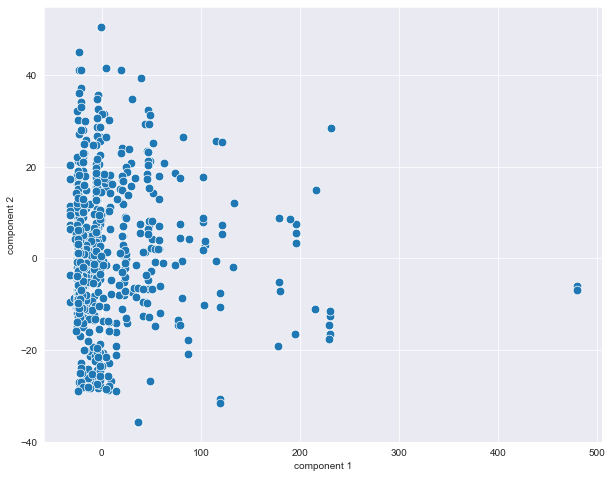

In [56]:
plt.figure(figsize = (10, 8))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1],s=75)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

# Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

params = {'fit_intercept': [True, False],    
        'C': [1, .5, .25, .1, .05, .025, .01, .005, .0025, .001]}

grid = GridSearchCV(LogisticRegression(), param_grid=params, return_train_score=True, verbose=3)
grid.fit(X, Y)
print('\n', f'{grid.best_estimator_} best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, fit_intercept=True;, score=(train=0.817, test=0.799) total time=   0.0s
[CV 2/5] END C=1, fit_intercept=True;, score=(train=0.818, test=0.820) total time=   0.0s
[CV 3/5] END C=1, fit_intercept=True;, score=(train=0.811, test=0.809) total time=   0.0s
[CV 4/5] END C=1, fit_intercept=True;, score=(train=0.815, test=0.798) total time=   0.0s
[CV 5/5] END C=1, fit_intercept=True;, score=(train=0.813, test=0.826) total time=   0.0s
[CV 1/5] END C=1, fit_intercept=False;, score=(train=0.816, test=0.793) total time=   0.0s
[CV 2/5] END C=1, fit_intercept=False;, score=(train=0.818, test=0.820) total time=   0.1s
[CV 3/5] END C=1, fit_intercept=False;, score=(train=0.811, test=0.803) total time=   0.2s
[CV 4/5] END C=1, fit_intercept=False;, score=(train=0.813, test=0.787) total time=   0.0s
[CV 5/5] END C=1, fit_intercept=False;, score=(train=0.811, test=0.831) total time=   0.0s
[CV 1/5] END C=0.5, fit_intercept

as you can see above the best model with optimum hyperparameters achieved 0.81 Accuracy.

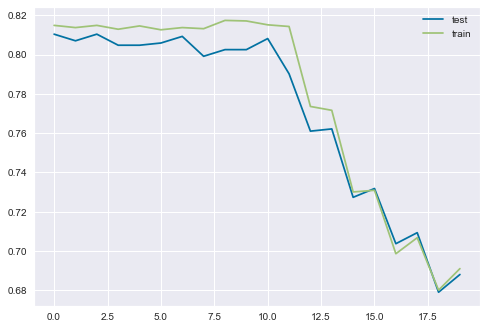

In [88]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

in the graph above you can see the validation curve for each hyperparmeter.

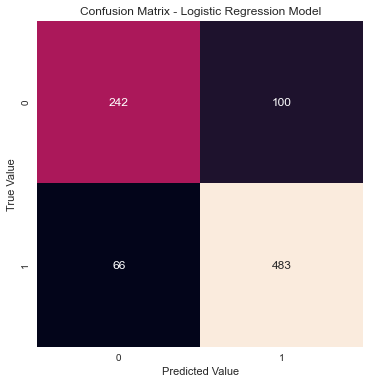

In [98]:
y_pred = grid.best_estimator_.predict(X)
cnf_matrix = confusion_matrix(Y, y_pred, labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix - Logistic Regression Model')
plt.show()

in the graph above you can see the confusion matrix of the most optimum logistic regression model.

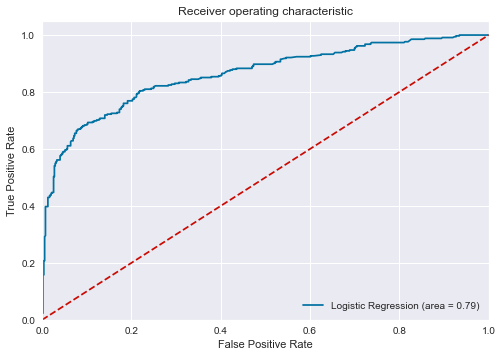

In [104]:
logit_roc_auc = roc_auc_score(Y, grid.predict(X))
fpr, tpr, thresholds = roc_curve(Y, grid.predict_proba(X)[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ROC curve is represented above

# !!!!!! In 3 ta graphe bala ro bokonam to ye graph !!!!!!!